<center> <img src = "https://images.theconversation.com/files/442675/original/file-20220126-17-1i0g402.jpg" style = "height:420px; width:960px; opacity: 1"/><center/>

# <center> Exploratory analysis of meteorological data <center/>

In this notebook, we display some practical data visualization techniques for analysing weather data. The dataset used in this example consists of measurements of several weather instruments, captured every 10 minutes, from the weather station of the **Max-Planck-Institute for Biogeochemistry in Jena, Germany in 2020**, and can be accessed with the following [**link**]( https://paperswithcode.com/dataset/weather-ltsf). For further details of the measured variables in the dataset, one should refer to the [**Documentation**](https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf) issued by the Max-Plank-Institude.

The notebook is structured as following:
- [Ridge Plot](#ridge)
- [Boxplot and Swarm Plot](#bspl)
- [Line Plot](#line)
- [Barplot](#barp)
- [Heatmap](#heat)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import  LinearSegmentedColormap

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
path = "../Data/"
filename = "Max_Planck_Institute_weather_dataset_2020.csv"
data = pd.read_csv(path + filename)

In [3]:
# Define functions 
## For data processing
def filter_column_name(column_name): # removes everything within the parenthesis
    try:
        idx = column_name.index("(") - 1
        return column_name[:idx]
        
    except ValueError: # the string doesn't contain any parenthesis
        return column_name
        
## For plotting
def modify_cmap(cmap_name, range, name): # modifies the color range of colormaps
    start, end, n_colors = range
    c_map = plt.cm.get_cmap(cmap_name)
    segment = [c_map(x) for x in np.linspace(start, end, n_colors)]
    custom_cmap = LinearSegmentedColormap.from_list(name, segment)
    return custom_cmap

In [4]:
# Process dataset
columns = [filter_column_name(x) for x in data.columns]
data.rename(columns={x:y for x, y in zip(data.columns, columns)}, inplace=True)
data['date'] = data.date.apply(pd.to_datetime)
data['month'] = data.date.dt.month.values
data['day'] = data.date.dt.day.values
data['day_nb'] = data.date.dt.dayofyear.values
data.drop(52695, inplace=True)

<a id="ridge"></a>
## Ridge Plot

In [5]:
def display_ridge_plot(data, category, hour, minute, second=[0], day=list(range(1, 32)), month=list(range(1, 13)), year=[2020], label="", title=""):
    # Data processing
    data = data[data.date.apply(lambda x: (x.year in year) and (x.month in month) and (x.day in day) and (x.hour in hour) and (x.minute in minute)\
                               and (x.second in second))]
    data['month'] = data.date.apply(lambda x: x.month)
    mean_cat_map = data[[category, 'month']].groupby('month')[category].mean()
    data[f"mean_{category}_month"] = data['month'].map(mean_cat_map)
    
    # Plot
    palette = sns.color_palette(palette='coolwarm', n_colors=12)
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 
          10: 'October', 11: 'November', 12: 'December'}

    grid = sns.FacetGrid(data, row='month', hue=f"mean_{category}_month", aspect=15, height=0.5, palette=palette)
    grid.map(sns.kdeplot, category, bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    grid.map(sns.kdeplot, category, bw_adjust=1, clip_on=False, color="w", lw=2)
    grid.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    list_months = [months[x] for x in data.month.unique()]
    for i, ax in enumerate(grid.axes.flat):
        ax.text(0, 0.02, list_months[i], fontweight='bold', fontsize=10, color=ax.lines[-1].get_color(), transform=ax.transAxes)
        
    # Show overlaps by hidding ax backgrounds
        ax.patch.set_alpha(0)
        
    grid.fig.subplots_adjust(hspace=-0.3) 
    grid.despine(bottom=True, left=True)
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.set_axis_labels(label, "", fontweight='bold', fontsize=10)
    plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold') # tick labels
    
    grid.fig.suptitle(title, fontsize=10, fontweight=20)
    plt.show()

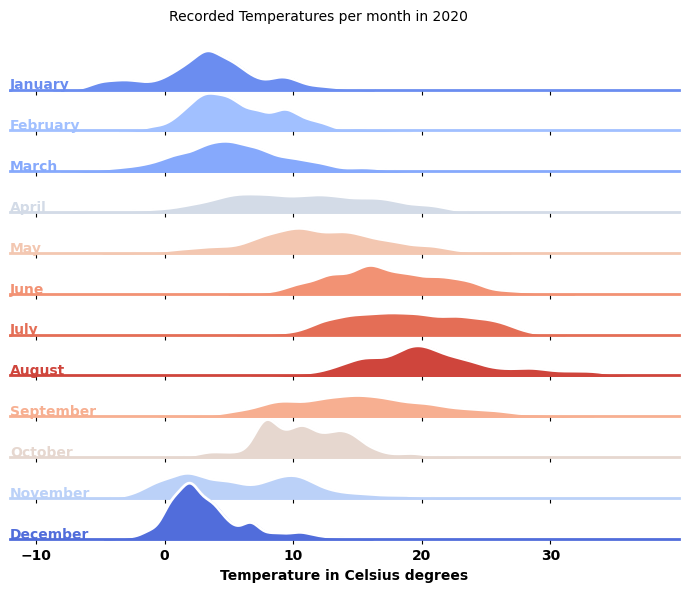

CPU times: total: 1.06 s
Wall time: 3.37 s


In [6]:
%%time
hour = list(range(24))
minute = list(range(60))
title = "Recorded Temperatures per month in 2020"
label = "Temperature in Celsius degrees"
args = dict(hour=hour, minute=minute, title=title, label=label)

display_ridge_plot(data, 'T', **args)

<a id="bspl"></a>
## Boxplot and Swarm plot

In [7]:
# Set style parameters
rc = {"grid.color": ".6", "grid.linestyle": "dotted"}
sns.set_style("darkgrid", rc=rc)

In [8]:
def display_box_plot(data, category, hour, minute, second=[0], day=list(range(1, 32)), month=list(range(1, 13)), year=[2020], label="", title="", ax=None):
     # Data processing
    data = data[data.date.apply(lambda x: (x.year in year) and (x.month in month) and (x.day in day) and (x.hour in hour) and (x.minute in minute)\
                               and (x.second in second))]
    data['month'] = data.date.apply(lambda x: x.month)
    mean_cat_map = data[[category, 'month']].groupby('month')[category].mean()
    data[f"mean_{category}_month"] = data['month'].map(mean_cat_map)
    
    # Plot
    palette = sns.color_palette(palette='coolwarm', n_colors=12)
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 
          10: 'October', 11: 'November', 12: 'December'}
    f = lambda x: months[x] if x in range(1, 13) else None

    sns.boxplot(data, x='month', y=category, ax=ax, boxprops={"alpha": 0.6}).set(title=title)
    sns.swarmplot(data, x='month', y=category, alpha=1, marker='.', ax=ax, hue='month', palette='husl', legend=None)
   
    plt.xticks(range(12), map(f, range(1, 13)), rotation=30)
    
    plt.show() if ax is None else None

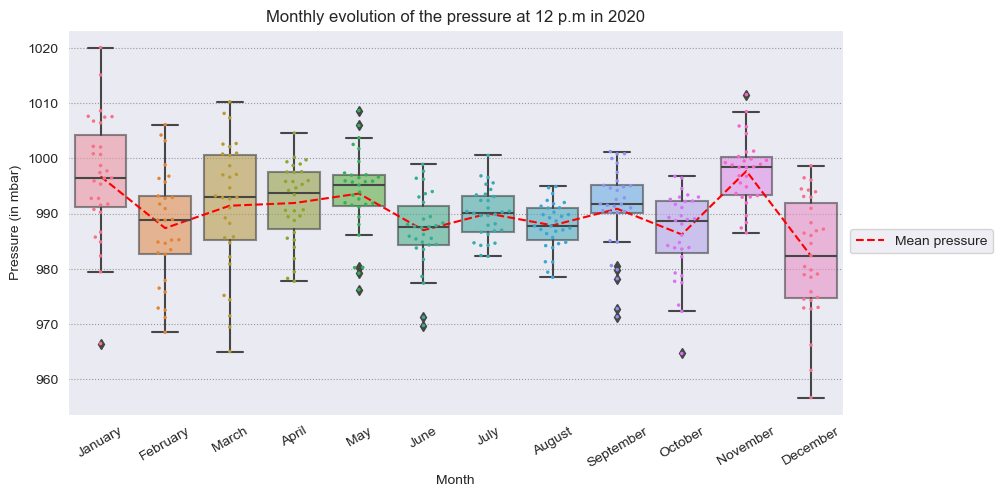

CPU times: total: 312 ms
Wall time: 751 ms


In [9]:
%%time
fig, ax = plt.subplots(figsize=(10, 5))

hour = [12]
minute = [0]
title = "Monthly evolution of the pressure at 12 p.m in 2020"
args = dict(hour=hour, minute=minute, title=title, label=label)

display_box_plot(data, 'p', ax=ax, **args)

# Adding mean pressure line
ax.plot(np.arange(12), data[data.date.apply(lambda x: x.hour == 12 and x.minute == 0)].groupby(['month'])['p'].mean(), color='red', \
       linestyle='dashed', label='Mean pressure')
ax.set_xlabel('Month')
ax.set_ylabel('Pressure (in mbar)')
ax.legend(bbox_to_anchor=(1, 0.5))
plt.show()

<a id="line"></a>
## Line Plot

In [10]:
# Adding new variable
acummulated_rain_map = data[['rain', 'day_nb']].groupby('day_nb')['rain'].sum()
data['acc_rain'] = data['day_nb'].map(acummulated_rain_map)
acummulated_rain_time_map = data[["day_nb", "raining"]].groupby("day_nb")['raining'].sum()/60
data['acc_rain_time'] = data['day_nb'].map(acummulated_rain_time_map)

In [11]:
def line_plot(x, y, title="", labels=["", "", ""], color="tab:blue", fcolor="navy", ax=None, t_labels=None, xticks=None, rotation=60):
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 5))

    ax.plot(x, y, color=color, label=labels[0], linewidth=1.25)
    ax.fill(x, y, color=fcolor, alpha=.45)
    ax.set_xticks(ticks=xticks, labels=t_labels, rotation=rotation) if (t_labels is not None and xticks is not None) else None
    ax.set_title(title, fontsize=14, fontweight=20)
    ax.set_xlabel(labels[1], fontsize=12)
    ax.set_ylabel(labels[2])
    # Dealing with legend
    h, l = ax.get_legend_handles_labels()
    ax.legend(handles=h, labels=l) if l[0] not in ["", None] else None
    plt.show() if ax is None else None

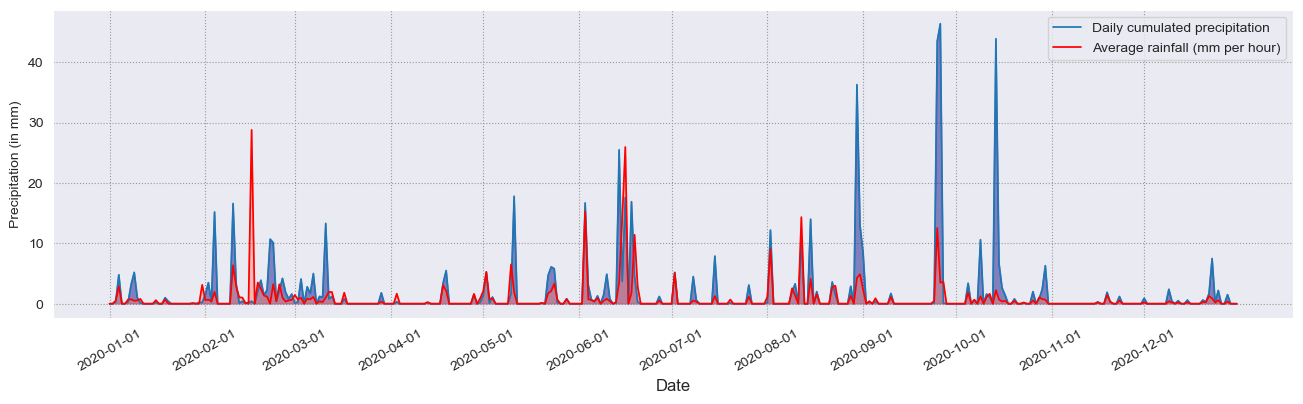

In [12]:
fig, ax = plt.subplots(figsize=(16, 4))

x = data.drop_duplicates(['day_nb', 'acc_rain']).date.dt.date.values
y = data.drop_duplicates(['day_nb', 'acc_rain']).acc_rain.values
y_ = data.drop_duplicates(['day_nb', 'acc_rain_time']).acc_rain_time.values
xlab = [date for date in x if date.day == 1] # tick labels

args = dict(ax=ax, xticks=xlab, t_labels=xlab, title="Precipitation in 2020",
           labels=["Daily cumulated precipitation", "Date", "Precipitation (in mm)"], rotation=30)

args_ = dict(ax=ax, xticks=xlab, t_labels=xlab, color="red", fcolor="salmon",
           labels=["Average rainfall (mm per hour)", "Date", "Precipitation (in mm)"], rotation=30)

line_plot(x, y, **args)
line_plot(x, [(60*v/v_) if (v_!=0) else 0 for (v,v_) in zip(y, y_)], **args_)
plt.show()

<a id="barp"></a>
## Barplot

In [13]:
# Extracting data into temporal dataframes
summer_prec = data.query("'2020-06-01' <= date < '2020-09-01'").groupby(['day_nb'])[['date', 'acc_rain']].mean() # dates of meteorological summer
mean_prec = summer_prec.acc_rain.mean()
summer_prec['acc_rain'] = summer_prec.acc_rain.apply(lambda x: x-mean_prec)
summer_prec['sign'] = summer_prec.acc_rain.apply(lambda x: np.sign(x)).astype(str)

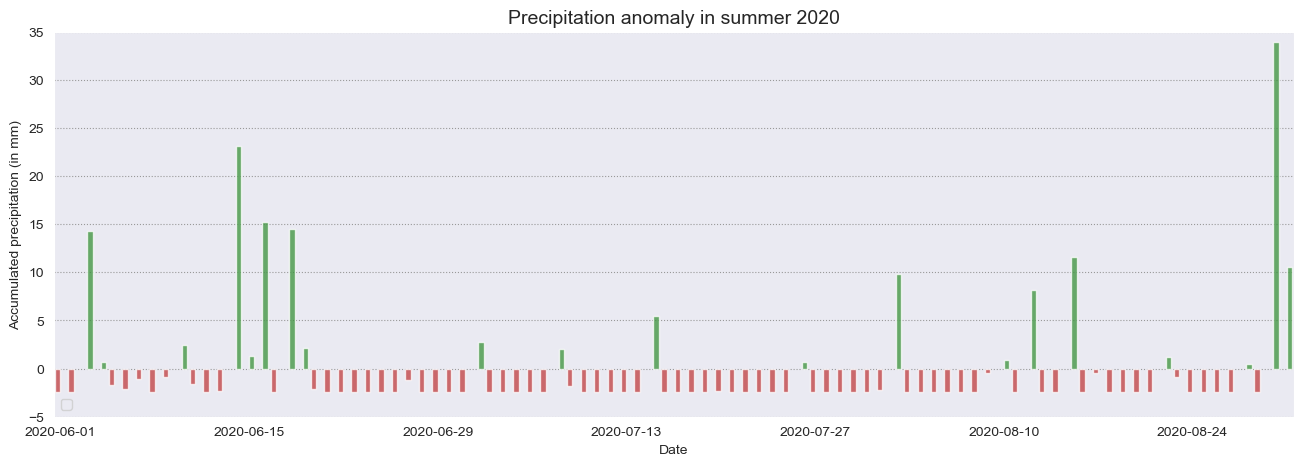

In [14]:
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(summer_prec, x='date', y='acc_rain', hue='sign', palette=sns.color_palette()[2:4][::-1], alpha=.75, ax=ax)
ticks = range(0, len(summer_prec), 14)
labels = summer_prec.date.dt.date.values[::14]
miny, maxy = np.round(summer_prec.acc_rain.min(), -1) - 5, np.round(summer_prec.acc_rain.max(), -1) + 5
ax.set_xticks(ticks=ticks, labels=labels, rotation=0)
ax.set_ylim(miny, maxy)
ax.set_xlabel("Date")
ax.set_ylabel("Accumulated precipitation (in mm)")
ax.set_title("Precipitation anomaly in summer 2020", fontsize=14)
ax.legend([])

plt.show()

<a id="heat"></a>
## Heatmap

In [15]:
# Extracting data into temporal dataframes
df_tmp = data.query("month==6").copy()
df_tmp['hour'] = df_tmp.date.dt.hour.values
df_tmp = df_tmp.groupby(['day', 'hour'])[['rain', 'T']].sum()

rainfall = np.zeros((24, 30))
heat = np.zeros((24, 30))
for i in range(1, 31):
    rainfall[:, i-1] = df_tmp.rain.loc[i].values.reshape(-1)
    heat[:, i-1] = df_tmp['T'].loc[i].values.reshape(-1)/6
    
rainfall = pd.DataFrame(rainfall, columns=range(1, 31), index=range(24))
heat = pd.DataFrame(heat, columns=range(1, 31), index=range(24))

#del df_tmp

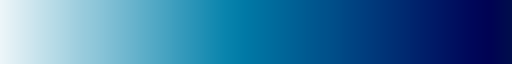

In [16]:
custom_cmap = modify_cmap('ocean_r', (0.025, 0.7, 26), 'Ocean_custom')

custom_cmap

### Example 1

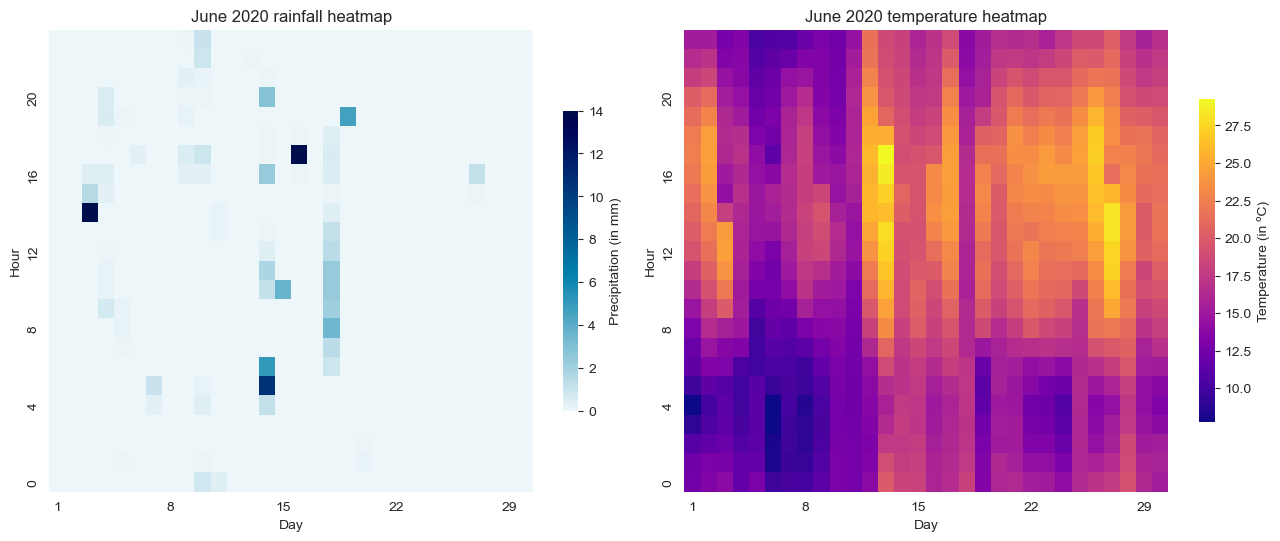

CPU times: total: 219 ms
Wall time: 511 ms


In [17]:
%%time
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.05)
# Rainfall heatmap
sns.heatmap(rainfall, vmax=14, cmap=custom_cmap, cbar_kws=dict(shrink=.65, label="Precipitation (in mm)"), ax=ax[0])
# Tempearture heatmap
sns.heatmap(heat, cmap='plasma', cbar_kws=dict(shrink=.7, label="Temperature (in ºC)"), ax=ax[1])

for ax_, title in zip(ax.ravel(), ['rainfall', 'temperature']):
    ax_.set_title("June 2020 {} heatmap".format(title), fontsize=12)
    ax_.set_xticks(ticks=np.arange(0, 30, 7)+0.5, labels=range(1, 31, 7), rotation=0)
    ax_.set_yticks(ticks=np.arange(0, 23, 4)+0.5, labels=range(0, 23, 4))
    ax_.invert_yaxis()
    ax_.set_ylabel("Hour")
    ax_.set_xlabel("Day")

plt.show()

### Example 2

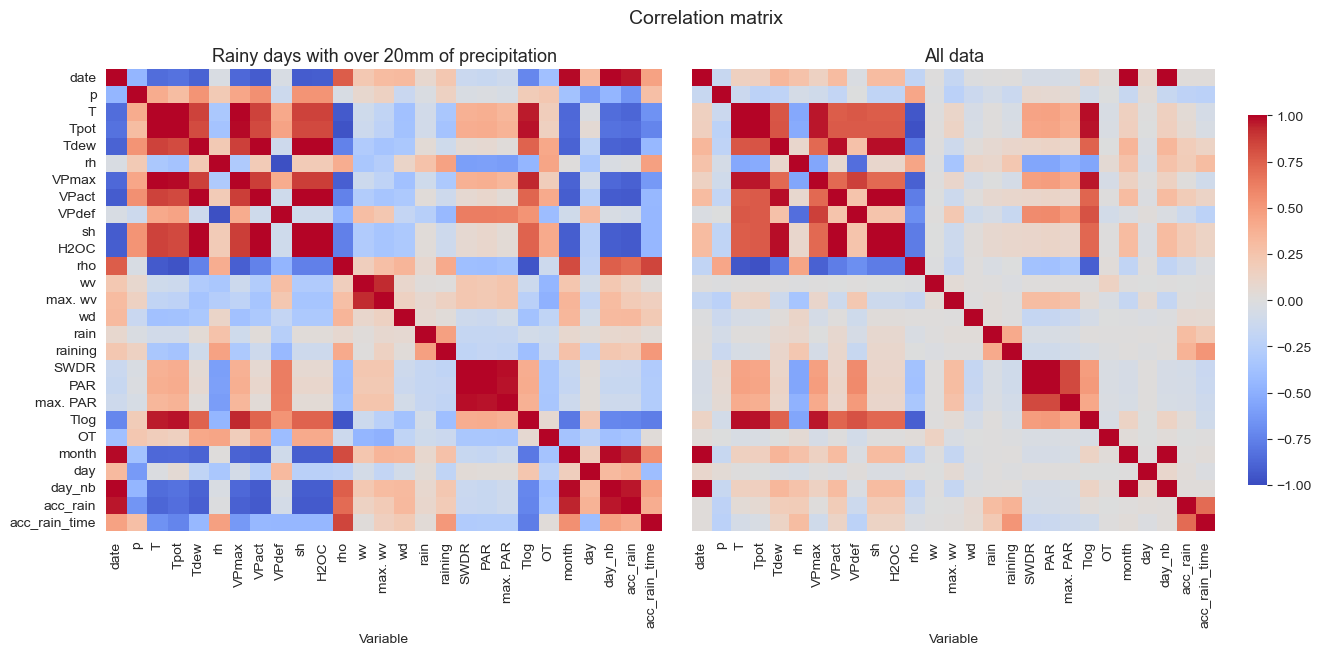

CPU times: total: 281 ms
Wall time: 1.08 s


In [18]:
%%time
fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [0.85, 1]})
fig.subplots_adjust(wspace=0.05)
# Rainfall heatmap
sns.heatmap(data[data.acc_rain.values > 20].corr(), vmin=-1, vmax=1, cmap="coolwarm", cbar=None, ax=ax[0])
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='coolwarm', cbar_kws=dict(shrink=.8), ax=ax[1])

for (i, ax_), title in zip(enumerate(ax.ravel()), ['Rainy days with over 20mm of precipitation', 'All data']):
    ax_.set_title("{}".format(title), fontsize=13)
    ax_.set_xlabel("Variable")
    ax_.set_yticks([]) if i>0 else None
    
plt.suptitle("Correlation matrix", fontsize=14)
plt.show()

In [481]:
Wc = lambda T, v : 13.12 + 0.6215 * T - 11.37 * v**0.16 + 0.3965 * T * v**0.16
At = lambda T, v, ea, Rn: T + 0.348 * ea - 0.7 * v + 0.7 * (Rn / (v + 10)) - 4.25
Rn = lambda a, Ri, eps_s, eps_a, sigma, Ts, Ta: (1 - a) * Ri - eps_s * (sigma * Ts)**4 + eps_a * (sigma * Ta)**4 

In [482]:
P = data.day_nb.max() * 24
Tm = data['T'].mean()
thd = 37.5 # Took the one from the paper (Izmir, TU) --> to change later
gamma = np.sqrt(np.pi / (thd * P))
z = 0.1 # arbitrary
Amp = lambda A0, z: A0 * np.exp(- gamma * z)
Ts = lambda Tm, A0, z, t0, t: Tm + Amp(A0, z) * np.sin(2*np.pi / P * (t-t0) - gamma*z - np.pi/2)

In [483]:
d0 = np.where(np.abs(data['T'] - Tm) < 5e-3)[0][0] # day for t0
d0 = data.loc[d0].day_nb
t0 = (d0 - 1) * 24

In [484]:
max_T = data[['day_nb', 'T']].groupby('day_nb').max()
min_T = data[['day_nb', 'T']].groupby('day_nb').min()
A0 = 0.5 * (max_T['T'].mean() - min_T['T'].mean()) # to review

In [485]:
# Compute hours elapsed since first recording (t)
data['recording_hour'] = data.date.apply(lambda x: x.hour + x.minute / 60) + data.day_nb.apply(lambda x: (x-1) * 24)
# Compute Soil temperature
data["Soil_temperature"] = data.recording_hour.apply(lambda x: Ts(Tm, A0, z, t0, x))

In [486]:
a = 0.05 # Albedo for wet, dark clay
sigma = 5.67e-8 # Stefan-Boltzmann constant
eps_s = 0.95 # soil emissivity for wet, dark clay
eps_a = lambda ea, T: 0.7 + 5.95 * 1e-4 * ea * np.exp(1500/(T + 273.1))
#ea = lambda RH, es: RH/100 * es
#es = lambda T: 0.6107 * np.exp(17.269 * T / (T + 273.1))

In [487]:
data["Net_absorved_radiation"] = data.SWDR.apply(lambda x: (1-a) * x) - eps_s * sigma**4 * data.Soil_temperature.apply(lambda x: x**4) + \
    0.7 + 5.95e-4 * data.VPact * data['T'].apply(lambda x: np.exp(1500/(x + 273.1))) * sigma**4 * data['T']**4

In [488]:
data["Apparent_temp"] = At(data["T"], data.wv,  0.7 + 5.95e-4 * data.VPact * data['T'].apply(lambda x: np.exp(1500/(x + 273.1))), \
    data.Net_absorved_radiation) # To review

In [489]:
data["Wind_chill"] = Wc(data["T"], data.wv)

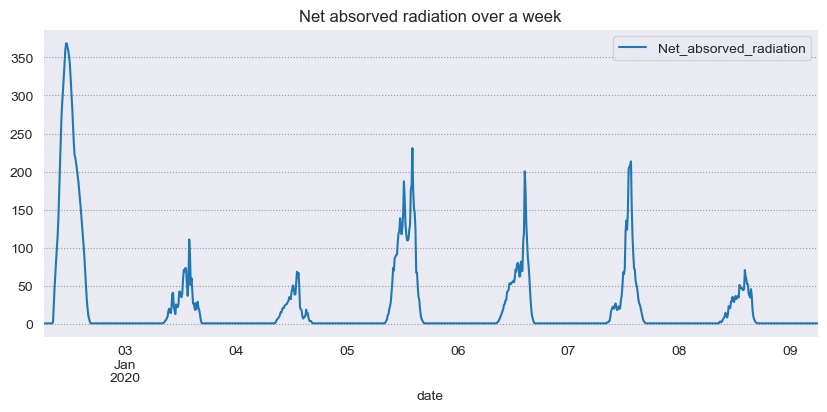

In [625]:
data.iloc[180:180+6*24*7].plot(x="date", y="Net_absorved_radiation", figsize=(10, 4))
plt.title("Net absorved radiation over a week")
plt.show()

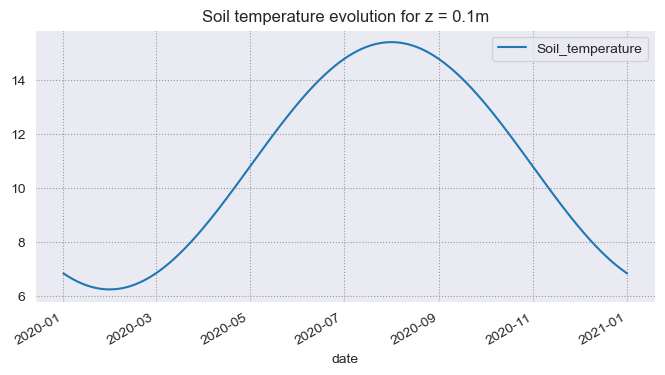

In [491]:
data.plot(x="date", y="Soil_temperature", figsize=(8, 4))
plt.title("Soil temperature evolution for z = 0.1m")
plt.show()

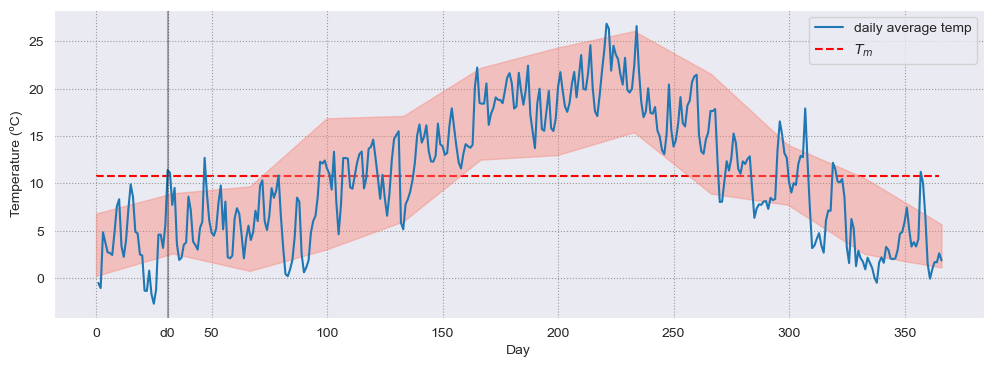

In [762]:
from matplotlib import text
_, ax = plt.subplots(figsize=(12, 4))
#ax.plot(max_T, label="daily max temp")
#ax.plot(min_T, label="daily min temp")
ax.plot(data[['day_nb', 'T']].groupby('day_nb').mean(), label="daily average temp")
ax.plot(Tm * np.ones(len(max_T)), color="r", linestyle="dashed", zorder=0, label="$T_{m}$")
ax.set_xlabel("Day")
ax.set_ylabel("Temperature (ºC)")
ax.fill_between(np.linspace(0, len(max_T), len(avg_min_temp)), avg_min_temp, avg_max_temp, color="salmon", alpha=0.4)
## custom ticks
xticks, labels = ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1]
# add tick
xticks = np.hstack((xticks, np.array([d0])))
labels += [text.Text(d0-3., 0, 'd0')]
# sort ticks and labels
labels.sort(key=lambda x:x.get_position()[0])
xticks=np.sort(xticks)
ax.axvline(x=d0, color="k", alpha=0.3)
ax.set_xticks(ticks=xticks, labels=labels)

plt.legend()
plt.show()